In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

En este script procesare los datos de la misma forma que el script V3 con la diferencia de
alguna transformacion externa de caracteristica. 
La prediccion la realizare con la tecniva voting classifier.

In [3]:
df_train = pd.read_csv('train.csv', index_col='id')
df_train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

In [5]:
# Castear variables float a enteras (teniendo en cuenta las fracciones de algunas caracteristicas)
def feature_float_int (df):
    df_copy = df.copy()
    columns_to_transform = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

    for i in columns_to_transform:
        if i == 'Age':                         
            df_copy[i]=df_copy[i].astype(int)
        else: df_copy[i]=round(df_copy[i]).astype(int)
        
    if any(df_copy[column].dtype !='int32' for column in columns_to_transform):
        print('Error: No se casteo correctamente alguna caracteristica')
        return df_copy
    
    print('Casteo realizado con exito')
    return df_copy

In [6]:
df_train = feature_float_int(df_train)
df_train.head()

Casteo realizado con exito


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24,1.699998,81.669950,yes,yes,2,3,Sometimes,no,3,no,0,1,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18,1.560000,57.000000,yes,yes,2,3,Frequently,no,2,no,1,1,no,Automobile,Normal_Weight
2,Female,18,1.711460,50.165754,yes,yes,2,1,Sometimes,no,2,no,1,2,no,Public_Transportation,Insufficient_Weight
3,Female,20,1.710730,131.274851,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31,1.914186,93.798055,yes,yes,3,2,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
# Eliminar valores atipicos de Age y Height

def delete_outliers (df):
    df_copy = df.copy()
    out=[]

    print('Tamaño del df antes de remover outliers:',df_copy.shape)
    columns_outliers = ['Age', 'Height']

    for i in columns_outliers:
        q1 = df_copy[i].quantile(0.25)
        q3 = df_copy[i].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 2.5 * iqr
        Upper_tail = q3 + 2.5 * iqr
    
        outliers = df_copy[(df_copy[i] < Lower_tail) | (df_copy[i] > Upper_tail)]
        out.extend(outliers.index)

    out = list(set(out))
    df_copy = df_copy.drop(out)
    print("Outliers removidos. Tamaño del nuevo df:", df_copy.shape)
    return df_copy

In [8]:
df_train= delete_outliers (df_train)

Tamaño del df antes de remover outliers: (20758, 17)
Outliers removidos. Tamaño del nuevo df: (20576, 17)


In [9]:
# Funcion que redondea a dos decimales altura y peso
def round_weight_height(df):
    df_copy = df.copy()
    columns = ['Height', 'Weight']

    for i in columns:
        df_copy[i] = round(df_copy[i],2)
    print('redondeo de peso y altura realizado')
    return df_copy

In [10]:
df_train = round_weight_height(df_train)

redondeo de peso y altura realizado


In [11]:
# Funcion que calcula el IMC y la añade como variable nueva
def imc_calculator(df):
    df_copy = df.copy()
    
    df_copy['IMC'] = round(df_copy['Weight']/(df_copy['Height']**2),1)
    print('Calculo de IMC insertado en columna nueva y realizado correctamente')
    return df_copy

In [12]:
df_train=imc_calculator(df_train)

Calculo de IMC insertado en columna nueva y realizado correctamente


In [13]:
# Movemos la variable objetivo al final de df
column_pop = df_train.pop('NObeyesdad')
df_train.insert(17, 'NObeyesdad', column_pop)

In [67]:
# Separamos en X e y
X = df_train.iloc[:, :-1]
y = df_train.iloc[:, 17]

In [15]:
# Funcion para eliminar columnas cuyas distribucion es < 90%
def del_column(X):
    X_copy = X.copy()

    X_copy.drop(['SMOKE', 'SCC'], inplace=True, axis=1)
    print('eliminacion de variables no entrenadas...')
    return X_copy

In [68]:
X = del_column(X)

eliminacion de variables no entrenadas...


In [57]:
X.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,MTRANS,IMC
id,,,,,,,,,,,,,,,
0,Male,24,1.70,81.67,yes,yes,2,3,Sometimes,3,0,1,Sometimes,Public_Transportation,28.3
1,Female,18,1.56,57.00,yes,yes,2,3,Frequently,2,1,1,no,Automobile,23.4
2,Female,18,1.71,50.17,yes,yes,2,1,Sometimes,2,1,2,no,Public_Transportation,17.2
3,Female,20,1.71,131.27,yes,yes,3,3,Sometimes,2,1,1,Sometimes,Public_Transportation,44.9
4,Male,31,1.91,93.80,yes,yes,3,2,Sometimes,2,2,1,Sometimes,Public_Transportation,25.7


In [18]:
# Codificar valores categoricos
def dummies_variable (X):
    X_copy = X.copy()
    categorical_var = X_copy.select_dtypes(include='object')

    # Creamos instancia de encoder
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(categorical_var)
    # Codificamos
    categorical_encoded = encoder.transform(categorical_var)

    # Convertimos a df
    X_copy = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_var.columns))
    print('Codificacion a dummies correctamente...')
    return X_copy

In [69]:
X_categorical = dummies_variable (X)

Codificacion a dummies correctamente...


In [20]:
# Normalizar los datos nuemericos
def normalizer_numerical (X):
    X_copy = X.copy()
    numerical_val = X_copy.select_dtypes(include='number')
    columns_name = numerical_val.columns
    # escalado y transformacion
    scaler = StandardScaler()
    nuemrical_scaled = scaler.fit_transform(numerical_val)

    # Convertimos a df
    numerical_df = pd.DataFrame(nuemrical_scaled, columns=columns_name)
    print('Normalizacion de variables numericas correcta')
    return numerical_df

In [70]:
X_numerical = normalizer_numerical (X)

Normalizacion de variables numericas correcta


In [22]:
# Funcion para concatenar categoricas y numericas
def concat_types(num,cat):
    X_ = pd.concat([num,cat], axis=1)
    print('Concatenacion realizada correctamente')
    return X_

In [71]:
X = concat_types(X_categorical,X_numerical)

Concatenacion realizada correctamente


In [40]:
# Elimino ciertas columnas cuya distribucion es menor del 90% de datos
def drop_features_(X):
        X.drop(['CAEC_no','CAEC_Always','CALC_Frequently','MTRANS_Bike','MTRANS_Motorbike', 
                'MTRANS_Walking', 'FAVC_yes', 'family_history_with_overweight_yes', 'Gender_Male'], axis =1, inplace=True)
        print('Eliminando algunas caracteristicas no entrenadas...')
        return X

In [72]:
X = drop_features_(X)

Eliminando algunas caracteristicas no entrenadas...


In [73]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20576 entries, 0 to 20575
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender_Female                      20576 non-null  float64
 1   family_history_with_overweight_no  20576 non-null  float64
 2   FAVC_no                            20576 non-null  float64
 3   CAEC_Frequently                    20576 non-null  float64
 4   CAEC_Sometimes                     20576 non-null  float64
 5   CALC_Sometimes                     20576 non-null  float64
 6   CALC_no                            20576 non-null  float64
 7   MTRANS_Automobile                  20576 non-null  float64
 8   MTRANS_Public_Transportation       20576 non-null  float64
 9   Age                                20576 non-null  float64
 10  Height                             20576 non-null  float64
 11  Weight                             20576 non-null  flo

Agrupacion por KMeans

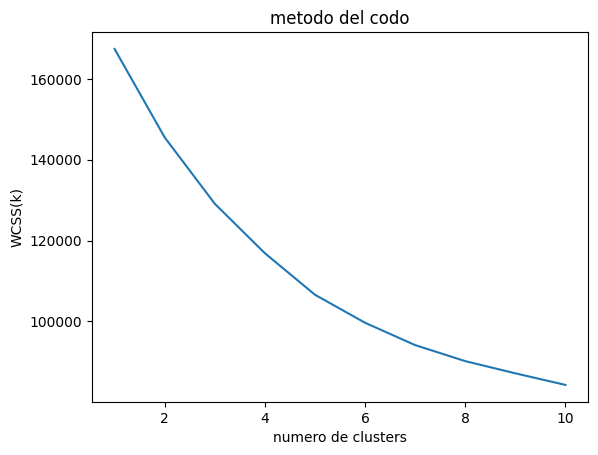

In [65]:
#sumatorio de cluster respecto a puntos y distancia a su centro
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X[['TUE','FAF','CH2O','NCP','FCVC','Height',
                                             'Age','MTRANS_Public_Transportation','MTRANS_Automobile',
                                             'CALC_no', 'CALC_Sometimes', 'CAEC_Sometimes',
                                             'CAEC_Frequently', 'FAVC_no', 'family_history_with_overweight_no']])
    #añadimos al final de wcss el sumatorio de los cuadrados de la distancia de k (inertia_)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('metodo del codo')
plt.xlabel('numero de clusters')
plt.ylabel('WCSS(k)')
plt.show()

In [101]:
def k_means(X):
    X_copy = X.copy()

    #Prediccion de clusters
    num_clusters = 5
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    pred_cluster = kmeans.fit_predict(X_copy[['TUE','FAF','CH2O','NCP','FCVC','Height',
                                             'Age','MTRANS_Public_Transportation','MTRANS_Automobile',
                                             'CALC_no', 'CALC_Sometimes', 'CAEC_Sometimes',
                                             'CAEC_Frequently', 'FAVC_no', 'family_history_with_overweight_no']])

    # Convertimos la columna a dummies
    clusters_dummies = pd.get_dummies(pred_cluster, prefix='cluster', dtype='float64')
    X_copy = pd.concat([X_copy, clusters_dummies], axis=1)
    print('Clusteres calculados y representados con exito')
    return X_copy
    

In [75]:
X = k_means(X)

In [102]:
# Funcion global de procesamiento de datos (en conjuntos de prueba)
def processing_data(df):
    df = feature_float_int(df)
    df=round_weight_height(df)
    df=imc_calculator(df)
    df = del_column(df)
    df_dummies = dummies_variable (df)
    df_normalizer=normalizer_numerical (df)
    df_concat = concat_types(df_dummies,df_normalizer)
    df_concat=drop_features_(df_concat)
    df_concat = k_means(df_concat)
    print('=======================')
    print('Procesamiento de datos completado con exito')
    return df_concat

In [78]:
# Entrenar modelo y mostrar resultados entrenamiento y validacion
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

Realizamos una prediccion simple en busca de las caractersticas mas relevantes a la hora de predecir

In [79]:
# Creamos un diccionario para establecer los labels en la variable y (necesario en el algoritmo XGBoost)
label_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Obesity_Type_I': 2,
    'Obesity_Type_II': 3,
    'Obesity_Type_III': 4,
    'Overweight_Level_I': 5,
    'Overweight_Level_II': 6
}

In [80]:
# Aplicar el mapeo a las etiquetas de entrenamiento
y_train_encoded = y_train.map(label_mapping)

# Aplicar el mapeo a las etiquetas de validacion
y_val_encoded = y_val.map(label_mapping)

In [81]:
# Algoritmo XGBoost
model = XGBClassifier(random_state=42 ,objective='multi:softmax')

In [82]:
# Entrenar el modelo
model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [83]:
# Obtener importancia de características
feature_importances = model.feature_importances_
# Nombres de caracteristicas
names_column = X_val.columns

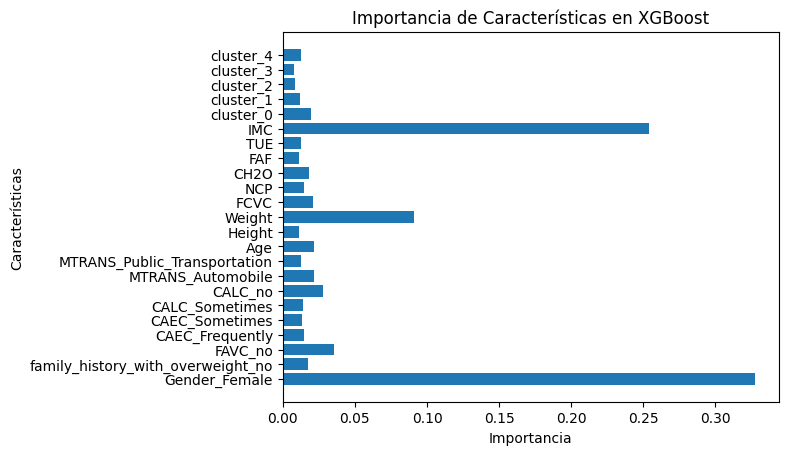

In [84]:
# Visualizar importancia de características con sus nombres
plt.barh(names_column, feature_importances)
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de Características en XGBoost')
plt.show()

Busqueda del modelo XGBoost con ajuste de hiperparametros automatico

In [87]:
# Definir la cuadrícula de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'learning_rate': uniform(0, 1),
    'n_estimators': randint(500, 2000),
    'gamma':uniform(0,1),
    'reg_alpha':uniform(0,1),
    'reg_lambda':uniform(0,1),
    'min_child_weight':randint(0,10),
    'max_depth': randint(4, 10),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
}

In [88]:
# Configurar la búsqueda aleatoria
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, 
                                   scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

In [89]:
# Realizar la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024C2E8BE750>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024C1CD65790>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024C2E8A2710>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024C1E03B750>},
                   scoring='accuracy', verbose=1)

In [90]:
# Obtenemos lso hiperparametros buscados
best_params = random_search.best_params_

In [91]:
xgb_clf = XGBClassifier(**best_params)

In [92]:
xgb_clf.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7620216541569584, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.30614955362193363,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4465988257501654,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=876, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [93]:
y_pred = xgb_clf.predict(X_val)

In [96]:
# Metrica accuracy score (requerida para la competicion)
print('El modelo base alcanza:',round(accuracy_score(y_val_encoded, y_pred), 3)*100,'% de precision')

El modelo base alcanza: 89.4 % de precision


Hacemos uso de la tecnica Hard Voting

In [97]:
# Crear clasificadores individuales
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42, max_iter=10000, multi_class='multinomial')

In [98]:
# Crear el Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('lr', lr_clf)
], voting='hard')

In [110]:
voting_clf.fit(X_train, y_train_encoded)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7620216541569584,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.30614955362193363,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=876, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=10000,
                                                 multi_class='multinomial',
                                                 random_state=42))])

In [99]:
# Validacion cruzada
scores = cross_val_score(voting_clf, X_train, y_train_encoded, cv=5) 
print("Precisión media de la validación cruzada:", "{:.2f}".format(scores.mean()))

Precisión media de la validación cruzada: 0.90


La validacion media es del 90%

In [100]:
# Funcion que da el valor categorico a cada clave del diccionario labels (necesario para volver a tener los valores como texto)
def label_to_text (pred, label_mapping):
    pred_copy = pred

    # Obtener las etiquetas originales en el mismo orden que los valores numéricos
    original_labels = [key for key, value in sorted(label_mapping.items(), key=lambda x: x[1])]

    # Mapear los valores numéricos a las etiquetas originales
    text_predictions = [original_labels[value] for value in pred_copy]
    return text_predictions

Predecir con el conjunto de prueba

In [103]:
df_prueba = pd.read_csv('test.csv')
df_prueba

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation
13836,34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
13837,34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation
13838,34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation


In [104]:
# Guardamos id
id_ = df_prueba['id']

In [105]:
# Eliminamos id
df_prueba.drop('id', axis=1, inplace=True)

In [106]:
df_prueba = processing_data(df_prueba)

Casteo realizado con exito
redondeo de peso y altura realizado
Calculo de IMC insertado en columna nueva y realizado correctamente
eliminacion de variables no entrenadas...
Codificacion a dummies correctamente...
Normalizacion de variables numericas correcta
Concatenacion realizada correctamente
Eliminando algunas caracteristicas no entrenadas...
Clusteres calculados y representados con exito
Procesamiento de datos completado con exito


In [107]:
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13840 entries, 0 to 13839
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender_Female                      13840 non-null  float64
 1   family_history_with_overweight_no  13840 non-null  float64
 2   FAVC_no                            13840 non-null  float64
 3   CAEC_Frequently                    13840 non-null  float64
 4   CAEC_Sometimes                     13840 non-null  float64
 5   CALC_Always                        13840 non-null  float64
 6   CALC_Sometimes                     13840 non-null  float64
 7   CALC_no                            13840 non-null  float64
 8   MTRANS_Automobile                  13840 non-null  float64
 9   MTRANS_Public_Transportation       13840 non-null  float64
 10  Age                                13840 non-null  float64
 11  Height                             13840 non-null  flo

In [108]:
# Eliminamos la columna 'CALC_Always' debido a que no esta entrenada en el conjunto de entrenamiento.
df_prueba.drop('CALC_Always', axis=1, inplace=True)

In [111]:
# Prediccion del modelo entrenado en el de prueba
prediction_ = voting_clf.predict(df_prueba)

In [112]:
# Convertimos a texto cada valor, dado el diccionario creado anteriormente
prediction_text = label_to_text(prediction_, label_mapping)

In [113]:
# Creamos el dataset de envio con la estructura exigida
submission = {'id': id_, 'NObeyesdad':prediction_text}

In [114]:
submit_v4_2 = pd.DataFrame(submission)
submit_v4_2

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [115]:
#Guardamos
submit_v4_2.to_csv('submitV4.2.csv', index=False)